# tSNE(t-distributed stochastic neighbor embedding)

## 符号定义
|符号|含义|
|:--:|:--:|
|$\pmb{x}$|数据点|
|X|数据点集合|
|N|数据点总数|
|$\pmb{y}$|降维后数据点|
|$p_{ij}$|原空间中数据点$\pmb{x_j}$与数据点$\pmb{x_i}$的联合概率|
|$q_{ij}$|低维空间中数据点$\pmb{y_j}$与数据点$\pmb{y_i}$的联合概率|
|$\mathcal{L}$|损失函数|
|$d$|原空间维度|
|$m$|降维后维度|
|$W$|权重矩阵|
|$D$|度矩阵|

## 概念

对于可视化来说，SNE有一个很大的问题(Crowding Problem)：不同类的数据聚集在一起，边界不清晰。若不手动标注类别信息很难区分不同的类。对于降维来说，这个问题始终存在，相较于低维空间，在高维空间中有更大的空间可供距离相同的点去分布。降维到低维后，可容纳这些点的空间不够，并且对于不同的距离，空间减小的程度不同，最终导致Crowding Problem。相较于距离较近的点，可容纳中等距离的点的空间减少的更多。反映到降维上就是：非常相近的数据聚集在一起，这没有问题；但是相距更远一些的数据会有相互远离的趋势。在SNE的优化过程中则会设法对这些相互远离的数据点施加“吸引力”使得这些点聚集到一起，最终导致不同类数据的分界线不明显。

上述问题的一个改进方式是人为添加“斥力”，这正是UNI-SNE的做法，但是并没有根本上解决Crowding Problem。

t-SNE在SNE的基础上有如下改进：
1. 使用对称SNE代替原有的SNE
2. 在低维空间使用t-分布代替高斯分布计算概率

其中第一点并不能解决上述的Crowding Problem，主要是使用联合概率$p_{ij}$以及$q_{ij}$代替了原有的条件概率$p_{j|i}$以及$q_{j|i}$。这样操作后，一方面优化更为简洁，另一方面相较于SNE也有一定的提升。

第二点才是t-SNE的主要工作。t-分布相较于高斯分布“更平”，即数据点落在离期望更远的位置的概率更大。

对于SNE系列方法，在高维空间计算联合概率实际上是在将距离转化为概率，在低维空间则是将概率转化为距离。当高维空间和低维空间使用相同的方法计算概率时，相当于距离保持，即保持高维空间内数据点之间的距离分布和低维空间内数据点之间的距离分布一致。t-SNE在低维空间中用t-分布代替了高斯分布，显然，对于高维空间中距离较远的两个点，其对应的利用高斯函数计算得到的联合概率也比较小，反映到t-分布中，同一概率则会对应到距离相对更远的两个点，从而实现高维空间中相距较远的两个点在降维后不至于相距过近。


## 推导

* **对称SNE**

SNE中使用的是条件概率，对于条件概率，$p_{i|j}$和$p_{j|i}$不相等，t-SNE中使用的是联合概率，其计算方式如下

对于高维空间有
$$
\begin{equation}
    p_{ij} = \frac{\exp(-||\pmb{x_i}-\pmb{x_j}||^2/2\sigma^2)}{\sum_{k\neq l}\exp(-||\pmb{x_k}-\pmb{x_l}||^2/2\sigma^2)}
\end{equation}
$$

对于低维空间有
$$
\begin{equation}
    q_{ij} = \frac{\exp(-||\pmb{y_i}-\pmb{y_j}||^2)}{\sum_{k\neq l}\exp(-||\pmb{y_k}-\pmb{y_l}||^2)}
\end{equation}
$$

对于高维空间中的点来说，式-1并不是一个非常合适的选择。原始数据分布可能相当分散，对于离群点，其与其他点的距离均较大，使得与该点相关的概率非常小，不利于对该点的降维结果进行监督。在t-SNE中，对于高维空间使用下式作为概率计算的方式
$$
\begin{equation}
    p_{ij} = \frac{p_{i|j} + p_{j|i}}{2N}
\end{equation}
$$

当将概率计算方式替换为式-2和式-3后，会得到一个更为简洁的梯度计算表达。
$$
\begin{equation}
    \frac{\partial{\mathcal{L}}}{\partial{\pmb{y_i}}} = 4\sum_{j=1}^N(p_{ij}-q_{ij})(\pmb{y_i}-\pmb{y_j})
\end{equation}
$$

* **t-分布计算联合概率**

式-2仍是使用高斯函数计算低维空间内的联合概率，t-SNE中将这一计算方式改为

$$
\begin{equation}
    q_{ij} = \frac{(1+||\pmb{y_i}-\pmb{y_j}||^2)^{-1}}{\sum_{k\neq l}(1+||\pmb{y_k}-\pmb{y_l}||^2)^{-1}}
\end{equation}
$$

* **损失函数与优化**

在式-3以及式-5的基础上可以得到对应的梯度计算方式

$$
\begin{equation}
    \frac{\partial{\mathcal{L}}}{\partial{\pmb{y_i}}} = 4\sum_{j=1}^N(p_{ij}-q_{ij})(\pmb{y_i}-\pmb{y_j})(1+||\pmb{y_i}-\pmb{y_j}||^2)^{-1}
\end{equation}
$$

t-SNE原论文中对SNE、UNI-SNE以及t-SNE不同距离下梯度计算结果的对比能很好的说明这三个算法的区别
![avatar](../images/SNE-UNISNE-tSNE.png)

图中正值表示两个点相互吸引（降维后两点距离有减小的趋势），负值表示两个点相互排斥（降维后两点距离有增大的趋势）

主要是分析两种极端情况：
1. 原空间中两点相距较远，而降维后，尚未优化前两点相距较近
2. 原空间中两点相距较近，而降维后，尚未优化前两点相距较远

首先分析SNE

从子图a的左侧区域可以判断SNE能很好的处理第二种情况，当发生第二种情况时，SNE会迅速减小两点的间的距离以匹配原空间中的距离；但是SNE无法处理第一种情况，当原空间中两点相距较远，而降维后两点距离较近时，SNE没有足够的“修正能力”（梯度太小）来修正这种错误

然后分析UNI-SNE

不同于SNE，UNI-SNE在整个范围内添加了一个基础“排斥力”。同样的，从子图b的左侧区域可以非常清晰的判断SNE能很好的处理第二种情况。但是对于第一种情况，UNI-SNE同样没能有效解决。并且可以注意到子图b的右上角区域，即原空间和降维空间距离均较大的区域梯度为负，这会导致该区域$q_{ij}$总是要大于$p_{ij}$

最后分析t-SNE

从子图c就能看出t-SNE对于上述两个问题有更好的表现。对于原空间相距较远，而降维后相距较近的两个点，t-SNE会促使这两个点相互远离（子图c底部靠近横轴区域）；对于原空间相距较近，而降维后相距较远的两个点，t-SNE会促使这两个点相互靠近（子图c左侧靠近纵轴区域）；而对于原空间以及降维空间距离相近的区域（子图c左下角以及右上角区域），t-SNE会尽量保持不变（梯度为0）

* **训练优化技巧**

t-SNE原论文给出了一些训练优化技巧，可以总结为如下几点

1. 带动量的梯度下降法
$$
\begin{equation}
    \pmb{y_i}(t+1) = \pmb{y_i}(t) - \eta\frac{\partial{\mathcal{L}}}{\partial{\pmb{y_i}}} + \alpha(t)(\pmb{y_i}(t) - \pmb{y_i}(t-1))
\end{equation}
$$
2. 学习率衰减。t-SNE中借鉴的Increased rates of convergence through learning rate adaptation
3. early exaggeration。在训练早期，将所有$p_{ij}$扩大一定倍数，这样操作后，会促使$q_{ij}$尽可能大，即使得训练早期所有相同类别的样本点尽可能聚集，不同类别的样本点则相互远离，以便于样本点以簇的形式迭代更新，并有利于形成比较好的全局结构

t-SNE还给出了一个训练流程示例：
1. 总迭代次数设定为1000
2. early exaggeration：设定early exaggeration=4训练50轮
3. 动量设置：前250轮设定动量为0.5，后续训练设定动量为0.8
4. 学习率设置：初始学习率为100，然后依照上述的学习率衰减策略进行学习率衰减。


## 算法步骤
1. 定义数据集$X$，降维后维度m
2. 确定参数$\sigma$
3. 在低维空间中随机生成降维结果
4. 利用下式计算降维前的联合概率
$$
p_{j|i} = \frac{\exp(-||\pmb{x_i}-\pmb{x_j}||^2/2\sigma^2)}{\sum_{k\neq i}\exp(-||\pmb{x_i}-\pmb{x_k}||^2/2\sigma^2)}
$$
$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
$$
5. 利用下式计算降维后的联合概率
$$
q_{ij} = \frac{(1+||\pmb{y_i}-\pmb{y_j}||^2)^{-1}}{\sum_{k\neq l}(1+||\pmb{y_k}-\pmb{y_l}||^2)^{-1}}
$$
6. 利用下式计算梯度
$$
\frac{\partial{\mathcal{L}}}{\partial{\pmb{y_i}}} = 4\sum_{j=1}^N(p_{ij}-q_{ij})(\pmb{y_i}-\pmb{y_j})(1+||\pmb{y_i}-\pmb{y_j}||^2)^{-1}
$$
7. 利用带动量的梯度下降法更新降维结果
$$
\pmb{y_i}(t+1) = \pmb{y_i}(t) - \eta\frac{\partial{\mathcal{L}}}{\partial{\pmb{y_i}}} + \alpha(t)(\pmb{y_i}(t) - \pmb{y_i}(t-1))
$$
8. 重复6、7步直至达到迭代停止条件

## 参考资料

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

L. Van der Maaten, G. Hinton. Visualizing data using t-SNE[J]. Journal of machine learning research, 2008, 9(11).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import torch
from torchvision import transforms, datasets

from sklearn.manifold import _utils, TSNE
from scipy.stats import entropy
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
class MytSNE(object):

    def __init__(self, n_components, perplexity, random_state, learning_rate, n_iter):

        self.n_components = n_components
        self.perplexity = perplexity
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.n_iter = n_iter

        self.condition_p = None
        self.condition_q = None
    
    def fit_transform(self, input_data, reduction_mat_init=None):
        self.input_data = np.array(input_data)
        n_samples, sample_dims = self.input_data.shape

        # compute condition p
        self._compute_condition_p(self.input_data)

        # create reduction result
        if reduction_mat_init is not None:
            reduction_mat = reduction_mat_init.copy()
        else:
            np.random.seed(self.random_state)
            reduction_mat = 1e-4 * np.random.randn(n_samples, self.n_components).astype(np.float32)

        # part 1
        # momentum: 0.5
        # early exaggeration：4
        # iter：250
        print("learning schedule part 1 begin...")
        self.condition_p *= 12.
        reduction_mat = self._optimize(reduction_mat, 0.5, 250, self.learning_rate, n_samples=n_samples)
        print("learning schedule part 1 done...")

        # part 2
        # momentum: 0.8
        # early exaggeration：1
        # iter：max_iter - 250
        print("learning schedule part 2 begin...")
        self.condition_p /= 12.
        reduction_mat = self._optimize(reduction_mat, 0.8, self.n_iter, self.learning_rate, n_samples=n_samples)
        print("learning schedule part 2 done...")

        return reduction_mat
    
    def _compute_condition_p(self, input_data):
        distance_vector = pairwise_distances(input_data, squared=True).astype(np.float32, copy=False)
        self.condition_p = _utils._binary_search_perplexity(distance_vector, self.perplexity, False)
        self.condition_p = (self.condition_p + self.condition_p.T)/(2 * np.sum(self.condition_p))
    
    def _optimize(self, params, momentum, max_iter, learning_rate, n_samples):
        
        temp_params = params.copy()
        temp_update_mat = np.zeros_like(params)
        gains = np.ones_like(params)

        for i in range(max_iter):

            train_loss, grad_mat = self.kl_loss(temp_params, n_samples)

            inc = temp_update_mat * grad_mat
            gains[np.argwhere(inc < 0)] += 0.2
            gains[np.argwhere(inc >= 0)] *= 0.8
            np.clip(gains, 0.01, np.inf, out=gains)
            grad_mat *= gains

            temp_update_mat = - learning_rate * grad_mat + momentum * temp_update_mat

            temp_params += temp_update_mat

        return temp_params

    def kl_loss(self, input_data, n_samples):
        distance_mat = pairwise_distances(input_data, squared=True).astype(np.float32, copy=False)
        distance_mat += 1. 
        distance_mat = np.power(distance_mat, -1)

        self.condition_q = distance_mat / (np.sum(distance_mat) - np.sum(np.diag(distance_mat)))

        _loss = np.sum(entropy(self.condition_p, self.condition_q))

        grad_mat = np.zeros((n_samples, self.n_components), dtype=input_data.dtype)

        PQd = (self.condition_p - self.condition_q) * distance_mat
        for i in range(n_samples):
            grad_mat[i] = np.matmul(PQd[i].reshape(1, -1), input_data[i] - input_data).reshape(-1)
        
        grad_mat *= 4.
        return _loss, grad_mat

learning schedule part 1 begin...
learning schedule part 1 done...
learning schedule part 2 begin...
learning schedule part 2 done...


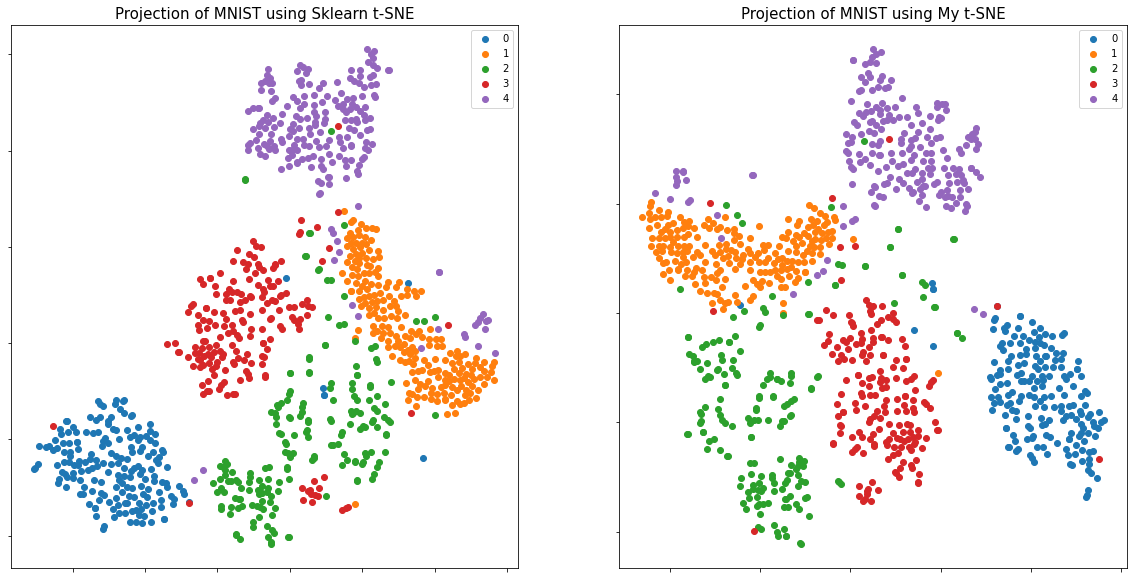

In [7]:
# ------------------------------- data -------------------------------------------
transform_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
data_total = datasets.MNIST('../data/mnist', train=True, transform=transform_, download=True)

# using 0~4
data_index = torch.where(data_total.targets < 5)
data_total.targets = data_total.targets[data_index][:1000]
data_total.data = data_total.data[data_index][:1000]

# init
np.random.seed(0)
reduction_init = 1e-4 * np.random.randn(data_total.data.numpy().shape[0], 2)

# ---------------------------- sklearn TSNE ---------------------------
sklearn_tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=100.0, n_iter=1000, method="exact", init=reduction_init)
sklearn_tsne_result = sklearn_tsne.fit_transform(data_total.data.numpy().reshape(-1, 28*28))

# ---------------------------- My TSNE ---------------------------
my_tsne = MytSNE(n_components=2, random_state=0, perplexity=50, learning_rate=100.0, n_iter=1000)
my_tsne_result = my_tsne.fit_transform(data_total.data.numpy().reshape(-1, 28*28), reduction_mat_init=reduction_init)

# ---------------------- draw --------------------------
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121)
plt.title("Projection of MNIST using Sklearn t-SNE", fontsize=15)
for i in np.unique(data_total.targets.numpy()):
    point_index_list = np.argwhere(data_total.targets == i)
    ax.scatter(sklearn_tsne_result[point_index_list, 0], sklearn_tsne_result[point_index_list, 1], cmap=plt.cm.Spectral, label=i)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")
plt.legend()

ax = fig.add_subplot(122)
plt.title("Projection of MNIST using My t-SNE", fontsize=15)
for i in np.unique(data_total.targets.numpy()):
    point_index_list = np.argwhere(data_total.targets == i)
    ax.scatter(my_tsne_result[point_index_list, 0], my_tsne_result[point_index_list, 1], cmap=plt.cm.Spectral, label=i)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")
plt.legend()
plt.show()